# Parsing Multiple Files for Modeling Transient Behaviour of Serverless Computing

In this file, we aim to average out several executions of the same workload pattern to get the average behavior of the platform.

In [1]:
%load_ext autoreload
%autoreload 2
# Imports

import os

import pacsltk.pacs_util as pacs_util
import trans_exp_parser as exp_parser
import trans_perf_model

import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import pacsltk
print(pacsltk.__version__)

0.1.13


In [2]:
csv_file_folder = os.path.join('results', 'exp1')
csv_file_list = [i for i in os.listdir(csv_file_folder) if '.csv' in i]

idle_mins_before_kill = 10
step_seconds = 10

tdfs = []
dfcs = []
for csv_filename in csv_file_list:
    csv_file = os.path.join(csv_file_folder, csv_filename)

    df = exp_parser.read_csv_file(csv_file)
    df = exp_parser.preprocess_df(df)
    tdf, time_idx = exp_parser.time_preprocess_df(df)

    parse_results = exp_parser.parse_instance_info(df, idle_mins_before_kill)
    # load results into local variables
    locals().update(parse_results)

    # tdf['instance_count'] = 
    df_counts = exp_parser.parse_counting_info(df, df_inst, step_seconds=step_seconds)
    df_counts['rps'] = tdf['is_cold'].resample('{}S'.format(step_seconds)).count() / step_seconds
    df_counts['p_cold'] = tdf['is_cold'].resample('{}S'.format(step_seconds)).mean()
    df_counts['rt'] = tdf['client_elapsed_time'].resample('{}S'.format(step_seconds)).mean() / 1000

    df_counts_smooth = df_counts.resample('T').mean()

    # Append the results to be used later
    tdfs.append(tdf)
    dfcs.append(df_counts_smooth)

In [3]:
tdfs[0].head()

,is_cold,inst_id,vm_id,elapsed_time,aws_duration,client_elapsed_time,client_start_time_dt,client_end_time_dt
client_start_time_dt,,,,,,,,
00:00:00,True,sandbox-8417a8,sandbox-root-BHH3hr,2010.156494,2010.96,2366.491556,2020-03-25 20:36:46.684891,2020-03-25 20:36:49.051382
00:00:00.346712,True,sandbox-80482c,sandbox-root-i7zqfu,2020.813965,2021.48,2582.517385,2020-03-25 20:36:47.031603,2020-03-25 20:36:49.614120
00:00:01.414425,True,sandbox-d15ed9,sandbox-root-uE6qOv,2043.438721,2043.55,2618.621349,2020-03-25 20:36:48.099316,2020-03-25 20:36:50.717938
00:00:02.686002,False,sandbox-8417a8,sandbox-root-BHH3hr,1765.493408,1765.44,1859.329462,2020-03-25 20:36:49.370893,2020-03-25 20:36:51.230223
00:00:03.154604,False,sandbox-80482c,sandbox-root-i7zqfu,1884.789551,1885.55,1974.874496,2020-03-25 20:36:49.839495,2020-03-25 20:36:51.814370


In [4]:
dfcs[0].tail()

,instance_count,running_count,running_warm_count,idle_count,utilization,rps,p_cold,rt
00:55:00,49.000000,13.500000,13.500000,35.500000,0.275510,7.066667,0.0,2.112090
00:56:00,49.000000,9.166667,9.166667,39.833333,0.187075,4.766667,0.0,2.116812
00:57:00,48.833333,6.500000,6.500000,42.333333,0.132866,3.116667,0.0,2.103055
00:58:00,48.000000,2.000000,2.000000,46.000000,0.041667,1.400000,0.0,2.092403
00:59:00,48.000000,1.000000,1.000000,47.000000,0.020833,1.100000,0.0,2.090262


In [5]:
# Getting the average behaviour
dfc = pd.DataFrame()
for col_name in dfcs[0].columns:
    tmpdf = pd.DataFrame()
    for i in range(len(dfcs)):
        tmpdf[col_name + "_" + str(i)] = dfcs[i][col_name]

    dfc[col_name] = tmpdf.mean(axis=1)

dfc.head()
csv_filename = "exp01-average.csv"
csv_file = os.path.join('results', csv_filename)
dfc.to_csv(csv_file)

In [6]:
mdf = dfc

# How many minutes to predict into future
pred_mins = 5

warm_service_time = df[df['is_cold'] == False]['client_elapsed_time'].mean() / 1000
cold_service_time = df[df['is_cold'] == True]['client_elapsed_time'].mean() / 1000
idle_time_before_kill = 10*60
max_t = 60

trans_predictions = []
for idx in range(mdf.shape[0] - pred_mins):
    pred_rpss = mdf['rps'].iloc[idx:idx+pred_mins].values
    init_server_count = int(mdf['instance_count'].iloc[idx])
    props = None
    for i in range(pred_mins):
        arrival_rate = pred_rpss[i]
        props, _ = trans_perf_model.get_sls_props_transient(arrival_rate, warm_service_time, 
                cold_service_time, idle_time_before_kill, max_t=max_t, 
                init_server_count=init_server_count)
        init_server_count = int(props['avg_server_count'])
        props['idx'] = mdf.index[idx]
        
    props['last_pred'] = pred_rpss[-1]
    trans_predictions.append(props)

pred_df = pd.DataFrame(trans_predictions)
pred_df.set_index('idx', inplace=True)
# shift to see predictions
from datetime import timedelta
pred_df.index = pred_df.index + timedelta(minutes=5)

## Making Plots to Compare Model and Experiments

In [7]:
import matplotlib.ticker as mticker
import datetime

# Prepare for plots
figs_folder = "figs"
pacs_util.prepare_matplotlib_cycler()

def get_fig_path(x): return (os.path.join(figs_folder, "exp" +
                                          x + ".png"), os.path.join(figs_folder, "exp" + x + ".pdf"))

def tmp_fig_save(fig_name):
    paths = get_fig_path(fig_name)
    plt.savefig(paths[0], dpi=300)
    plt.savefig(paths[1])

def plot_configs(ylab, is_texp=True):
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.xlabel("Experiment Time (MM:SS)")
    plt.ylabel(ylab)
    plt.gcf().subplots_adjust(left=0.17, bottom=0.22)
    if is_texp:
        pacs_util.fix_timedelta(1e-3)

    def timeTicks(x, pos):
        d = datetime.timedelta(seconds=x/1e9)
        s = str(d)
        return ":".join(s.split(":")[1:3])

    formatter = mticker.FuncFormatter(timeTicks)
    plt.gca().xaxis.set_major_formatter(formatter)

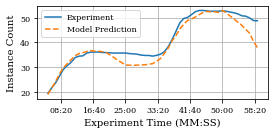

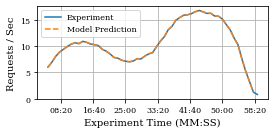

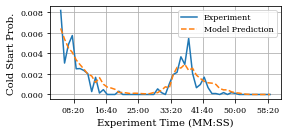

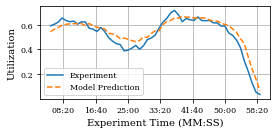

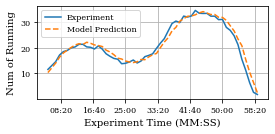

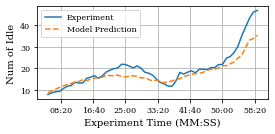

In [8]:
# Remove the parts we don't have a prediction for
def make_plots(mdf, pred_df, prefix=None):
    mdf = mdf[mdf.index >= pred_df.index.min()]

    plt.figure(figsize=(4,1.8))
    plt.plot(mdf['instance_count'], label='Experiment')
    plt.plot(pred_df['avg_server_count'], label='Model Prediction')
    plot_configs("Instance Count")
    if prefix is not None:
        tmp_fig_save(prefix+"_instance_count")

    plt.figure(figsize=(4,1.8))
    plt.plot(mdf['rps'], label='Experiment')
    plt.plot(pred_df['last_pred'].shift(-1), label='Model Prediction')
    plot_configs("Requests / Sec")
    if prefix is not None:
        tmp_fig_save(prefix+"_rps")

    plt.figure(figsize=(4,1.8))
    plt.plot(mdf['p_cold'], label='Experiment')
    plt.plot(pred_df['cold_prob'], label='Model Prediction')
    plot_configs("Cold Start Prob.")
    if prefix is not None:
        tmp_fig_save(prefix+"_p_cold")

    plt.figure(figsize=(4,1.8))
    plt.plot(mdf['utilization'], label='Experiment')
    plt.plot(pred_df['avg_utilization'], label='Model Prediction')
    plot_configs("Utilization")
    if prefix is not None:
        tmp_fig_save(prefix+"_utilization")

    plt.figure(figsize=(4,1.8))
    plt.plot(mdf['running_count'], label='Experiment')
    plt.plot(pred_df['avg_running_count'], label='Model Prediction')
    plot_configs("Num of Running")
    if prefix is not None:
        tmp_fig_save(prefix+"_running_count")

    plt.figure(figsize=(4,1.8))
    plt.plot(mdf['idle_count'], label='Experiment')
    plt.plot(pred_df['avg_idle_count'], label='Model Prediction')
    plot_configs("Num of Idle")
    if prefix is not None:
        tmp_fig_save(prefix+"_idle_count")

make_plots(mdf, pred_df, prefix='01')